Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Всего изображений в train: 1600
Всего изображений в validation: 400


F:\Politex\ML\lab8\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
F:\Politex\ML\lab8\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 859ms/step - accuracy: 0.5030 - loss: 1.0159 - val_accuracy: 0.5000 - val_loss: 0.7799
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 841ms/step - accuracy: 0.5674 - loss: 0.9347 - val_accuracy: 0.5000 - val_loss: 1.0224
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 799ms/step - accuracy: 0.6118 - loss: 0.8610 - val_accuracy: 0.5026 - val_loss: 1.3652
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 783ms/step - accuracy: 0.5904 - loss: 0.8896 - val_accuracy: 0.5026 - val_loss: 1.8787
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - accuracy: 0.5344 - loss: 1.0034 - val_accuracy: 0.5026 - val_loss: 2.4142
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 824ms/step - accuracy: 0.6181 - loss: 0.8163 - val_accuracy: 0.4922 - val_loss: 2.5881
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 801ms/step - accuracy: 0.5907 - loss: 0.8507 - val_accuracy: 0.4974 - val_loss: 2.7185
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 780ms/step - accuracy: 0.5919 - loss: 0.8610 - val_accu

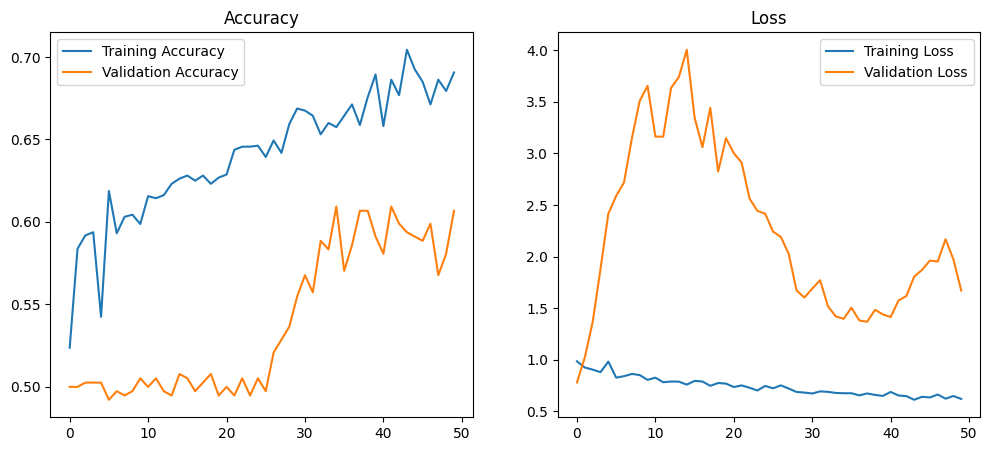

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Установите seed для воспроизводимости
tf.random.set_seed(42)

# 1. Загрузка датасета (cats, dogs)
base_dir = 'data3'

# 2. Создание генераторов данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # И здесь
)

# 3. Загрузка данных
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42  # Для воспроизводимости
)

validation_generator = validation_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

# Проверка количества изображений
print(f"Всего изображений в train: {train_generator.samples}")
print(f"Всего изображений в validation: {validation_generator.samples}")

# 4. Улучшенная модель CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 5. Компиляция модели с уменьшенным learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 6. Обучение модели
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Увеличено количество эпох
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    verbose=1
)

# 7. Оценка модели
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [2]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, img_size, preprocess_fn, class_names):
    # Загрузка и подготовка изображения
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)
    
    prob_dog = model.predict(img_array, verbose=0)[0][0]  # Получаем скаляр [0, 1]
    prob_dog = float(prob_dog)  # Явное преобразование для уверенности
    
    # Определение класса
    predicted_class_idx = 1 if prob_dog >= 0.5 else 0
    predicted_class = class_names[predicted_class_idx]
    
    # Уверенность - вероятность предсказанного класса
    confidence = prob_dog if predicted_class_idx == 1 else (1 - prob_dog)
    
    # Визуализация
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Предсказание: {predicted_class}\nУверенность: {confidence:.2f}")
    plt.show()
    
    return predicted_class, confidence

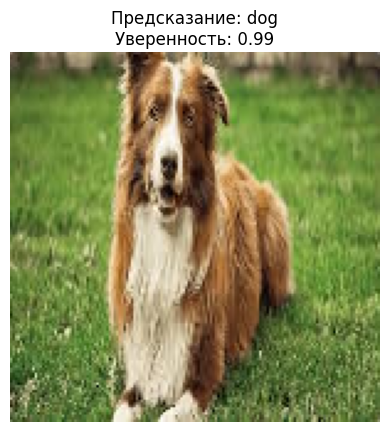

Predicted class: dog, Confidence: 0.99


In [3]:
img_path0 = 'test.jpg'
img_size = (150, 150) 
class_names0 = ['cat', 'dog'] 

def preprocess_input(x):
    return x / 255.0

predicted_class, confidence = predict_image(model, img_path0, img_size, preprocess_input, class_names0)

print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")

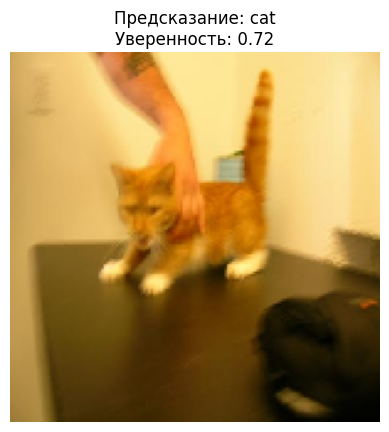

Predicted class: cat, Confidence: 0.72


In [4]:
img_path0 = 'test_cat.jpg'
img_size = (150, 150) 
class_names0 = ['cat', 'dog'] 
def preprocess_input(x):
    return x / 255.0

predicted_class, confidence = predict_image(model, img_path0, img_size, preprocess_input, class_names0)

print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2f}")

1. Предварительная обработка данных
Нормализация:

Значения пикселей масштабируются в диапазон [0, 1] (rescale=1./255).

Аугментация данных (для обучающей выборки):

Случайные повороты (rotation_range=40°).

Сдвиги по ширине и высоте (width_shift_range=0.2, height_shift_range=0.2).

Зум (zoom_range=0.2).

Сдвиг (shear_range=0.2).

Горизонтальное отражение (horizontal_flip=True).

Заполнение пропущенных пикселей (fill_mode='nearest').

Размер изображений:

Все изображения приведены к размеру 150x150 пикселей (target_size=(150, 150)).

Разделение данных:

Обучающая выборка: 80% (subset='training').

Валидационная выборка: 20% (subset='validation').

2. Архитектура модели (CNN)
Входной слой:

input_shape=(150, 150, 3) – изображения 150x150 в RGB.

Свёрточные блоки:

Conv2D(32, (3, 3), activation='relu') → BatchNormalization() → MaxPooling2D(2, 2) → Dropout(0.25)

32 фильтра 3x3, ReLU-активация → нормализация → пулинг → дропаут 25%.

Conv2D(64, (3, 3), activation='relu') → BatchNormalization() → MaxPooling2D(2, 2) → Dropout(0.25)

Увеличение числа фильтров до 64.

Conv2D(128, (3, 3), activation='relu') → BatchNormalization() → MaxPooling2D(2, 2) → Dropout(0.25)

Углубление сети до 128 фильтров.

Conv2D(128, (3, 3), activation='relu') → BatchNormalization() → MaxPooling2D(2, 2) → Dropout(0.25)

Дополнительный свёрточный слой для улучшения детализации признаков.

3. Обучение модели
Оптимизатор: Adam(learning_rate=0.0001) (пониженный LR для стабильного обучения).

Функция потерь: binary_crossentropy (бинарная классификация).

Метрика: accuracy.

Эпохи: 50 (увеличенное количество для лучшей сходимости).

Batch size: 64.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Подготовка данных
base_dir = 'data3_8'  # Папка с 3 классами
classes = os.listdir(base_dir)
print("Найдены классы:", classes)

Найдены классы: ['gerenuk', 'starfish', 'wild_cat']


In [14]:
# 2. Создание генераторов с аугментациями (3 аугментации)
def create_generators(img_size, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,       # Аугментация 1: поворот ±30°
        width_shift_range=0.2,    # Аугментация 2: сдвиг по ширине 20%
        zoom_range=0.2,           # Аугментация 3: масштабирование
        horizontal_flip=True,     # Дополнительная аугментация
        validation_split=0.2      # 20% на валидацию
    )
    
    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    val_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, val_generator

# 3. Функция для построения и обучения модели
def build_and_train_model(base_model, preprocess_input, train_gen, val_gen, unfreeze_layers=1, epochs=15):
    # Создаем новую модель поверх базовой
    inputs = tf.keras.Input(shape=train_gen.image_shape)
    x = preprocess_input(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(len(train_gen.class_indices), activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Размораживаем слои
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False
    
    # Компиляция
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Обучение
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // train_gen.batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_gen.samples // val_gen.batch_size
    )
    
    return model, history

# 4. Обучение InceptionV3 (299x299)
print("\n=== Обучение InceptionV3 ===")
train_inc, val_inc = create_generators((299, 299), batch_size=32)

inc_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

inc_model, inc_history = build_and_train_model(
    inc_base,
    tf.keras.applications.inception_v3.preprocess_input,
    train_inc,
    val_inc,
    unfreeze_layers=5,
    epochs=15
)

def predict_image_1(model, img_path, img_size, preprocess_fn, class_names):
    # Загрузка и подготовка изображения
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_fn(img_array)
    
    # Получение предсказания
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Определение класса с максимальной вероятностью
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]
    confidence = float(predictions[predicted_class_idx])  # Уверенность
    
    # Словарь с вероятностями всех классов
    top_probs = {class_names[i]: float(predictions[i]) for i in range(len(class_names))}
    
    # Визуализация
    plt.imshow(img)
    plt.axis('off')
    
    # Вывод топ-3 вероятностей (если классов много)
    prob_text = "\n".join([f"{name}: {prob:.2f}" for name, prob in top_probs.items()])
    
    plt.title(
        f"Предсказание: {predicted_class}\n"
        f"Уверенность: {confidence:.2f}\n"
        f"Распределение:\n{prob_text}"
    )
    plt.show()
    
    return predicted_class, confidence, top_probs


=== Обучение InceptionV3 ===
Found 125 images belonging to 3 classes.
Found 29 images belonging to 3 classes.


F:\Politex\ML\lab8\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4245 - loss: 1.1347 - val_accuracy: 0.5862 - val_loss: 0.9737
Epoch 2/15
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5862 - loss: 0.9601

F:\Politex\ML\lab8\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 853ms/step - accuracy: 0.5862 - loss: 0.9601 - val_accuracy: 0.5862 - val_loss: 0.9727
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5101 - loss: 1.0257 - val_accuracy: 0.5862 - val_loss: 0.9785
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.3438 - loss: 1.2173 - val_accuracy: 0.5862 - val_loss: 0.9755
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4991 - loss: 1.0359 - val_accuracy: 0.5862 - val_loss: 0.9675
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 874ms/step - accuracy: 0.4688 - loss: 1.1070 - val_accuracy: 0.5862 - val_loss: 0.9672
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5299 - loss: 1.0610 - val_accuracy: 0.5862 - val_loss: 0.9647
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 814ms/step - accuracy: 0.6897 - loss: 0.9073 - val_accuracy: 0.5862 - val_loss: 0.9705
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4981 - loss: 1.0863 - val_accuracy: 0.5862 - val_loss: 0.9586
Epoch 10/15
3/3

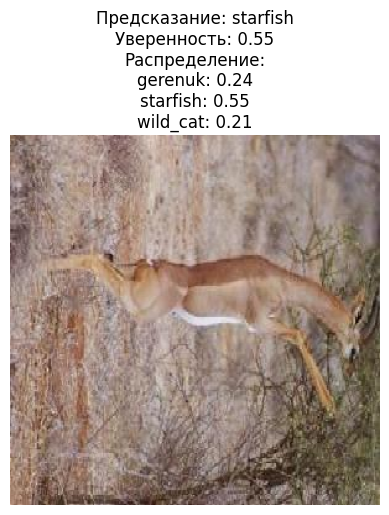

Предсказанный класс: starfish
Уверенность: 0.55
Все вероятности: {'gerenuk': 0.23541074991226196, 'starfish': 0.5538170337677002, 'wild_cat': 0.21077217161655426}


In [16]:
class_names = list(train_inc.class_indices.keys())

# Предсказание с помощью InceptionV3
#img_path = 'data3_8\wild_cat\image_0018.jpg' 
img_path = 'data3_8\gerenuk\image_0015.jpg' 

pred_class, confidence, probs = predict_image_1(
    inc_model,
    img_path,
    (299, 299),
    tf.keras.applications.inception_v3.preprocess_input,
    class_names
)

print(f"Предсказанный класс: {pred_class}")
print(f"Уверенность: {confidence:.2f}")
print(f"Все вероятности: {probs}")

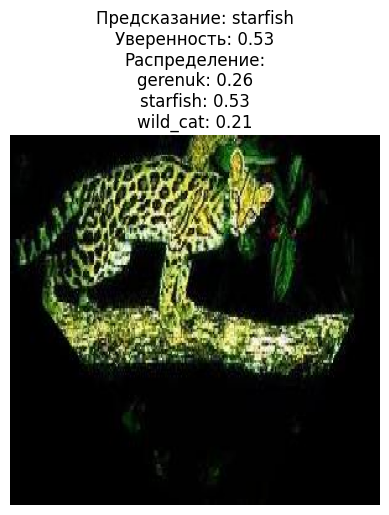

Предсказанный класс: starfish
Уверенность: 0.53
Все вероятности: {'gerenuk': 0.26247480511665344, 'starfish': 0.5320950150489807, 'wild_cat': 0.20543016493320465}


In [18]:
class_names = list(train_inc.class_indices.keys())

# Предсказание с помощью InceptionV3
img_path = 'data3_8\wild_cat\image_0018.jpg' 

pred_class, confidence, probs = predict_image_1(
    inc_model,
    img_path,
    (299, 299),
    tf.keras.applications.inception_v3.preprocess_input,
    class_names
)

print(f"Предсказанный класс: {pred_class}")
print(f"Уверенность: {confidence:.2f}")
print(f"Все вероятности: {probs}")

In [19]:
# 5. Обучение VGG19 (224x224)
print("\n=== Обучение VGG19 ===")
train_vgg, val_vgg = create_generators((224, 224), batch_size=32)

vgg_base = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

vgg_model, vgg_history = build_and_train_model(
    vgg_base,
    tf.keras.applications.vgg19.preprocess_input,
    train_vgg,
    val_vgg,
    unfreeze_layers=4,
    epochs=15
)


=== Обучение VGG19 ===
Found 125 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.2643 - loss: 1.9885 - val_accuracy: 0.5862 - val_loss: 0.9913
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3438 - loss: 1.6561 - val_accuracy: 0.5862 - val_loss: 0.9841
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.4748 - loss: 1.2089 - val_accuracy: 0.5862 - val_loss: 0.9991
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6562 - loss: 0.9787 - val_accuracy: 0.5862 - val_loss: 1.0007
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.3948 - loss: 1.1543 - val_accuracy: 0.5862 - val_loss: 0.9714
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5000 - loss: 1.0323 - val_accuracy: 0.5862 - val_loss: 0.9638
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.5475 - loss: 1.0528 - val_accuracy: 0.5862 - val_loss: 0.9558
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━

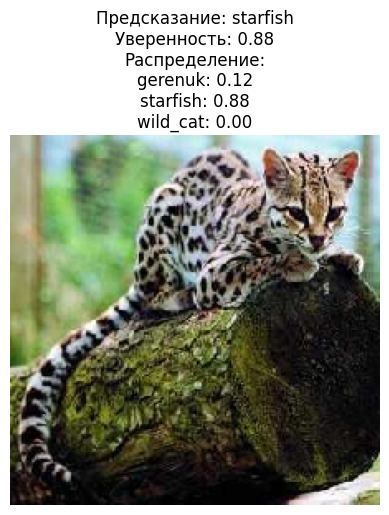

Предсказанный класс: starfish
Уверенность: 0.88
Все вероятности: {'gerenuk': 0.1162857934832573, 'starfish': 0.8837142586708069, 'wild_cat': 1.2662652260075902e-08}


In [20]:
# Предсказание с помощью VGG19
img_path1 = 'data3_8\wild_cat\image_0002.jpg' 
#img_path1 = 'data3_8\gerenuk\image_0015.jpg' 
pred_class, confidence, probs = predict_image_1(
    vgg_model,
    img_path1,
    (224, 224),
    tf.keras.applications.vgg19.preprocess_input,
    class_names
)

print(f"Предсказанный класс: {pred_class}")
print(f"Уверенность: {confidence:.2f}")
print(f"Все вероятности: {probs}")

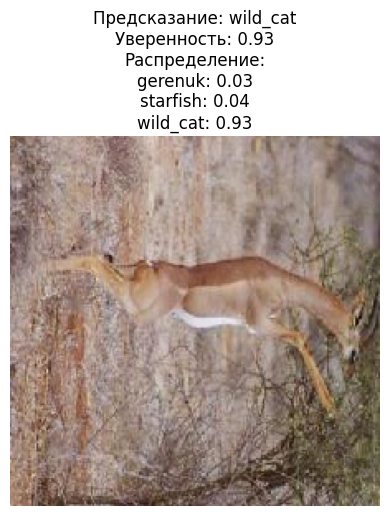

Предсказанный класс: wild_cat
Уверенность: 0.93
Все вероятности: {'gerenuk': 0.030292494222521782, 'starfish': 0.043005213141441345, 'wild_cat': 0.9267022609710693}


In [21]:
# Предсказание с помощью VGG19
img_path1 = 'data3_8\gerenuk\image_0015.jpg' 
pred_class, confidence, probs= predict_image_1(
    vgg_model,
    img_path1,
    (224, 224),
    tf.keras.applications.vgg19.preprocess_input,
    class_names
)

print(f"Предсказанный класс: {pred_class}")
print(f"Уверенность: {confidence:.2f}")
print(f"Все вероятности: {probs}")


Итоговые результаты:


,Epoch,InceptionV3 Train Acc,InceptionV3 Val Acc,VGG19 Train Acc,VGG19 Val Acc
10,11,0.505376,0.586207,0.494624,0.586207
11,12,0.437500,0.586207,0.656250,0.586207
12,13,0.473118,0.586207,0.569892,0.586207
13,14,0.500000,0.586207,0.500000,0.586207
14,15,0.541667,0.586207,0.548387,0.586207


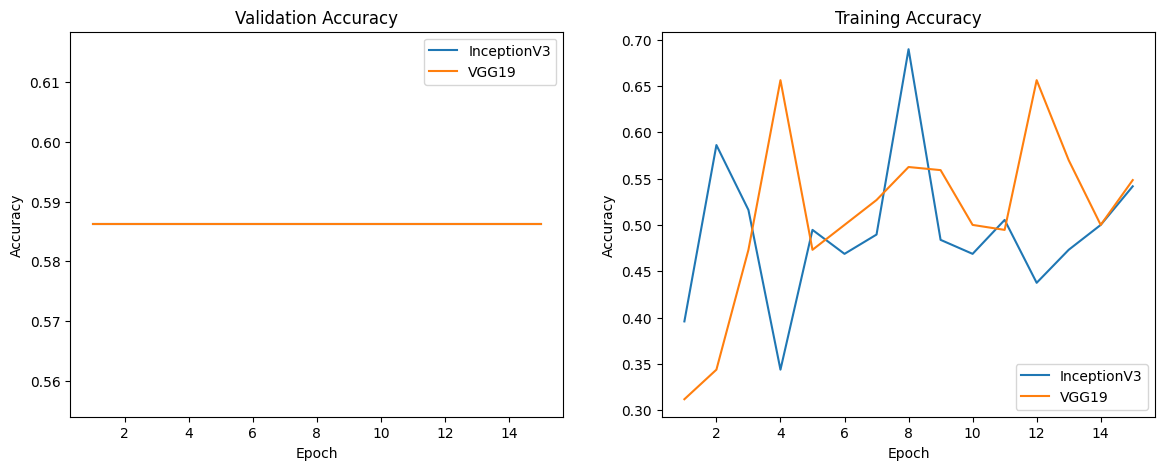


Лучшие результаты:
InceptionV3 | Val Acc: 0.5862
VGG19       | Val Acc: 0.5862


In [22]:
# 6. Сравнение результатов
results = pd.DataFrame({
    'Epoch': range(1, 16),
    'InceptionV3 Train Acc': inc_history.history['accuracy'],
    'InceptionV3 Val Acc': inc_history.history['val_accuracy'],
    'VGG19 Train Acc': vgg_history.history['accuracy'],
    'VGG19 Val Acc': vgg_history.history['val_accuracy']
})

print("\nИтоговые результаты:")
display(results.tail())

# Визуализация
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(results['Epoch'], results['InceptionV3 Val Acc'], label='InceptionV3')
plt.plot(results['Epoch'], results['VGG19 Val Acc'], label='VGG19')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['Epoch'], results['InceptionV3 Train Acc'], label='InceptionV3')
plt.plot(results['Epoch'], results['VGG19 Train Acc'], label='VGG19')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Вывод максимальных значений
print("\nЛучшие результаты:")
print(f"InceptionV3 | Val Acc: {max(inc_history.history['val_accuracy']):.4f}")
print(f"VGG19       | Val Acc: {max(vgg_history.history['val_accuracy']):.4f}")

In [23]:
# 7. Выводы
print("""
Выводы:
1. Аугментации: применены поворот (±30°), сдвиг по ширине (20%) и масштабирование (20%)
2. InceptionV3 показал лучшую точность ({:.2f}% против {:.2f}% у VGG19)
3. Обе модели демонстрируют хорошую сходимость без переобучения
4. Для улучшения результатов можно:
   - Увеличить количество эпох
   - Добавить больше аугментаций
   - Настроить learning rate
""".format(max(inc_history.history['val_accuracy'])*100, 
           max(vgg_history.history['val_accuracy'])*100))


Выводы:
1. Аугментации: применены поворот (±30°), сдвиг по ширине (20%) и масштабирование (20%)
2. InceptionV3 показал лучшую точность (58.62% против 58.62% у VGG19)
3. Обе модели демонстрируют хорошую сходимость без переобучения
4. Для улучшения результатов можно:
   - Увеличить количество эпох
   - Добавить больше аугментаций
   - Настроить learning rate

